In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from vocab import Vocabulary
from env2 import ConceptData
from create_data import addFile
import tensorflow as tf
import random
import numpy as np
import csv
import re
import os
import create_data
from xml.dom import minidom
import xml.etree.ElementTree as ET
import agents
import sender2
import game2
from agents import find_lengths

In [2]:
NUM_OPTIONS = 10
NUM_DISTRACTORS = 9
BATCH_SIZE = 32
HIDDEN_SIZE = 50
EMBED_DIM = 50
VOCAB_SIZE = 99
MAX_LEN = 10
NUM_EPOCHS = 2000
TRAINING = True
SENDER_ALL_INPUT = False
sender_entropy_coeff = 0.015 #wie bei Ossenkopf
receiver_entropy_coeff = 0.0 # wie bei Ossenkopf


In [3]:

vocabulary = Vocabulary()

def addFile(name):
    file_name = name + "_structured_final.xml"
    file = minidom.parse(os.path.join(os.path.join('visa_dataset', 'UK'), file_name))
    concepts = file.getElementsByTagName('concept')

    for concept in concepts:
        vocabulary.addConcept(concept)


addFile("ANIMALS")
addFile("APPLIANCES")
addFile("ARTEFACTS")
addFile("CLOTHING")
addFile("CONTAINER")
addFile("DEVICE")
addFile("FOOD")
addFile("HOME")
addFile("INSTRUMENTS")
addFile("MATERIAL")
addFile("PLANTS")
addFile("STRUCTURES")
addFile("TOOLS")
addFile("TOYS")
addFile("VEHICLES")
addFile("WEAPONS")

for concept in vocabulary.concept_list:
    vocabulary.parseConcept(concept)

In [4]:
#Initialisiere die Agents
sender_encoder_only_target = sender2.SenderOnlyTarget(hidden_size=EMBED_DIM, batch_size=BATCH_SIZE)
sender_LSTM = sender2.Sender_LSTM(agent = sender_encoder_only_target,
                                    embed_dim=EMBED_DIM,
                                    num_cells=1,
                                    hidden_size=1, 
                                    max_len=MAX_LEN,
                                see_all_input=SENDER_ALL_INPUT)
receiver_encoder = agents.Receiver(hidden_size=EMBED_DIM, num_options = NUM_OPTIONS)
receiver_LSTM = agents.Receiver_LSTM(agent=receiver_encoder, 
                                       vocab_size=VOCAB_SIZE,
                                       embed_dim=EMBED_DIM, 
                                       hidden_size=HIDDEN_SIZE)
guesser = agents.AuxiliaryNetwork(hidden_size=HIDDEN_SIZE)


In [5]:
#the losses

#loss of guessing the correct target
def loss(_sender_input, _message, _receiver_input, input_concepts, receiver_output, targets):
    """
    receiver_output ist was von receiver_sampling zurückgegeben wird
    LABELS PRINTEN IN OSSSENKOPF NOTEBOOK
    """
    guesses = []
    
    for i in range(len(receiver_output)):
        guesses.append(input_concepts[i][receiver_output[i]])
            
    guesses = tf.convert_to_tensor(guesses)
    targets = tf.convert_to_tensor(targets)
    acc = np.sum(guesses == targets) - np.sum(guesses != targets)
        
    return -acc

#auxiliary loss to promote empathy
def auxiliary_loss(receiver_thoughts, 
                  # _message, _receiver_input, 
                   guesser_output, 
                   #_labels,
                   weight=0.2):
    mae = tf.keras.losses.MeanAbsoluteError(reduction = 'none')
    loss = mae(receiver_thoughts, guesser_output)
    loss *= weight
    
    return loss

In [6]:
game = game2.Game(sender_encoder=sender_encoder_only_target,
                  sender=sender_LSTM,
                receiver=receiver_LSTM,
                main_loss=loss,
                sender_entr_coeff=sender_entropy_coeff,
                receiver_entr_coeff=receiver_entropy_coeff,
                batch_size=BATCH_SIZE,
                max_len=MAX_LEN,
                 sender_all_input=SENDER_ALL_INPUT)

In [7]:
optim_guesser = tf.keras.optimizers.Adam(learning_rate = 1e-3)
optim_receiver = tf.keras.optimizers.Adam(learning_rate = 1e-2)
optim_sender = tf.keras.optimizers.Adam(learning_rate = 1e-3)
#optim_game = tf.keras.optimizers.Adam(learning_rate = 1e-5)

In [8]:
losses_network = []
losses_aux = []
accuracy = []
main_loss = []
train_steps = []

for i in range(NUM_EPOCHS):
   
    data = ConceptData(voc=vocabulary, num_distractors=NUM_DISTRACTORS, batch_size=BATCH_SIZE)
    input_concepts, sender_input, targets, receiver_input = data.getInputDifferent()
    
    
    with tf.GradientTape(persistent=True) as tape:
        
        loss, prev_hidden, last_hidden, acc, message = game(input_concepts, sender_input, targets, receiver_input)
        losses_network.append(np.mean(loss))
        receiver_gradients = tape.gradient(loss, game.receiver.trainable_variables)
        sender_lstm_gradients = tape.gradient(loss, game.sender.trainable_variables)
        sender_encoder_gradients = tape.gradient(loss, game.sender_encoder.trainable_variables)
                   

    optim_receiver.apply_gradients((grad, var) for (grad, var) in zip(receiver_gradients, game.receiver.trainable_variables) if grad is not None)
    optim_sender.apply_gradients((grad, var) for (grad, var) in zip(sender_lstm_gradients, game.sender.trainable_variables) if grad is not None)
    
    with tf.GradientTape() as tape:
        
        guesser_output = guesser(prev_hidden)
        aux_loss = auxiliary_loss(last_hidden, guesser_output)
        aux_loss_mean = np.mean(aux_loss)
        
        if i % 25 == 0:
            train_steps.append(i)
            losses_aux.append(aux_loss_mean)
            main_loss.append(np.mean(loss))
            accuracy.append(np.mean(acc))
        
        aux_gradients = tape.gradient(aux_loss, guesser.trainable_variables)
        
        # add gradients of guesser onto gradients of sender_encoder to update sender_encoder with these
        #sender_encoder_grad_all = []
        #for i in range(len(aux_gradients)):
            #sender_encoder_grad_all.append(aux_gradients[i] + sender_encoder_gradients[i])
        
    optim_guesser.apply_gradients(zip(aux_gradients, guesser.trainable_variables))
    #optim_sender.apply_gradients(zip(sender_encoder_grad_all, game.sender_encoder.trainable_variables))
    print(f'epoch::: {i}   loss::: {np.mean(loss)}   acc::: {acc}   aux_loss::: {aux_loss_mean}')
        

epoch::: 0   loss::: -426.49365234375   acc::: -28.0   aux_loss::: 0.099391870200634
epoch::: 1   loss::: -426.408203125   acc::: -28.0   aux_loss::: 0.09900814294815063
epoch::: 2   loss::: -396.05615234375   acc::: -26.0   aux_loss::: 0.09983155131340027
epoch::: 3   loss::: -304.641357421875   acc::: -20.0   aux_loss::: 0.10092797875404358
epoch::: 4   loss::: -365.81640625   acc::: -24.0   aux_loss::: 0.1014215350151062
epoch::: 5   loss::: -334.5087890625   acc::: -24.0   aux_loss::: 0.10286390781402588
epoch::: 6   loss::: -395.4913330078125   acc::: -26.0   aux_loss::: 0.10522773861885071
epoch::: 7   loss::: -395.961181640625   acc::: -26.0   aux_loss::: 0.10559992492198944
epoch::: 8   loss::: -395.96160888671875   acc::: -26.0   aux_loss::: 0.105425626039505
epoch::: 9   loss::: -304.587890625   acc::: -20.0   aux_loss::: 0.10519560426473618
epoch::: 10   loss::: -365.44305419921875   acc::: -24.0   aux_loss::: 0.10447566211223602
epoch::: 11   loss::: -487.63470458984375   a

epoch::: 79   loss::: -277.93939208984375   acc::: -20.0   aux_loss::: 0.10103822499513626
epoch::: 80   loss::: -389.907958984375   acc::: -28.0   aux_loss::: 0.10106728971004486
epoch::: 81   loss::: -417.6011047363281   acc::: -30.0   aux_loss::: 0.10101929306983948
epoch::: 82   loss::: -361.60430908203125   acc::: -26.0   aux_loss::: 0.10090136528015137
epoch::: 83   loss::: -304.2449951171875   acc::: -20.0   aux_loss::: 0.10073834657669067
epoch::: 84   loss::: -389.9245910644531   acc::: -28.0   aux_loss::: 0.10054904222488403
epoch::: 85   loss::: -416.8426513671875   acc::: -30.0   aux_loss::: 0.10025491565465927
epoch::: 86   loss::: -388.64959716796875   acc::: -28.0   aux_loss::: 0.09952843189239502
epoch::: 87   loss::: -364.52490234375   acc::: -24.0   aux_loss::: 0.09885801374912262
epoch::: 88   loss::: -365.36285400390625   acc::: -24.0   aux_loss::: 0.09786757826805115
epoch::: 89   loss::: -304.84295654296875   acc::: -22.0   aux_loss::: 0.09652479737997055
epoch:::

epoch::: 170   loss::: -277.93212890625   acc::: -20.0   aux_loss::: 0.09409578144550323
epoch::: 171   loss::: -393.4481201171875   acc::: -26.0   aux_loss::: 0.09398218244314194
epoch::: 172   loss::: -393.9600830078125   acc::: -26.0   aux_loss::: 0.09365294128656387
epoch::: 173   loss::: -426.3203125   acc::: -28.0   aux_loss::: 0.09330910444259644
epoch::: 174   loss::: -484.331787109375   acc::: -32.0   aux_loss::: 0.0926758199930191
epoch::: 175   loss::: -301.92645263671875   acc::: -20.0   aux_loss::: 0.09250148385763168
epoch::: 176   loss::: -299.260498046875   acc::: -20.0   aux_loss::: 0.09349167346954346
epoch::: 177   loss::: -355.1376953125   acc::: -24.0   aux_loss::: 0.09581904113292694
epoch::: 178   loss::: -383.26416015625   acc::: -26.0   aux_loss::: 0.09675073623657227
epoch::: 179   loss::: -412.61279296875   acc::: -28.0   aux_loss::: 0.0971493124961853
epoch::: 180   loss::: -294.5259704589844   acc::: -22.0   aux_loss::: 0.0971049964427948
epoch::: 181   los

epoch::: 261   loss::: -410.75244140625   acc::: -30.0   aux_loss::: 0.08938311785459518
epoch::: 262   loss::: -337.4537353515625   acc::: -22.0   aux_loss::: 0.08919261395931244
epoch::: 263   loss::: -393.7767333984375   acc::: -26.0   aux_loss::: 0.08913218230009079
epoch::: 264   loss::: -361.166259765625   acc::: -24.0   aux_loss::: 0.08910724520683289
epoch::: 265   loss::: -418.087646484375   acc::: -28.0   aux_loss::: 0.08894791454076767
epoch::: 266   loss::: -452.4954833984375   acc::: -30.0   aux_loss::: 0.0887499749660492
epoch::: 267   loss::: -359.84515380859375   acc::: -26.0   aux_loss::: 0.08857367932796478
epoch::: 268   loss::: -455.228271484375   acc::: -30.0   aux_loss::: 0.08848181366920471
epoch::: 269   loss::: -295.74102783203125   acc::: -20.0   aux_loss::: 0.08835846930742264
epoch::: 270   loss::: -450.263916015625   acc::: -30.0   aux_loss::: 0.08828826993703842
epoch::: 271   loss::: -329.13690185546875   acc::: -24.0   aux_loss::: 0.08828090131282806
epo

epoch::: 352   loss::: -348.92376708984375   acc::: -24.0   aux_loss::: 0.0912061333656311
epoch::: 353   loss::: -373.1651916503906   acc::: -28.0   aux_loss::: 0.09123571217060089
epoch::: 354   loss::: -286.6168212890625   acc::: -20.0   aux_loss::: 0.09120707213878632
epoch::: 355   loss::: -409.25018310546875   acc::: -28.0   aux_loss::: 0.09111029654741287
epoch::: 356   loss::: -418.837890625   acc::: -28.0   aux_loss::: 0.09105059504508972
epoch::: 357   loss::: -383.95166015625   acc::: -26.0   aux_loss::: 0.09103917330503464
epoch::: 358   loss::: -350.73956298828125   acc::: -24.0   aux_loss::: 0.09104083478450775
epoch::: 359   loss::: -353.6041259765625   acc::: -24.0   aux_loss::: 0.09104971587657928
epoch::: 360   loss::: -421.1446533203125   acc::: -28.0   aux_loss::: 0.0909920483827591
epoch::: 361   loss::: -438.247314453125   acc::: -30.0   aux_loss::: 0.09097161144018173
epoch::: 362   loss::: -326.6539306640625   acc::: -22.0   aux_loss::: 0.09091732650995255
epoch

epoch::: 443   loss::: -326.40966796875   acc::: -24.0   aux_loss::: 0.08757585287094116
epoch::: 444   loss::: -405.32171630859375   acc::: -28.0   aux_loss::: 0.08753403276205063
epoch::: 445   loss::: -442.302734375   acc::: -30.0   aux_loss::: 0.08739341795444489
epoch::: 446   loss::: -386.26904296875   acc::: -26.0   aux_loss::: 0.08724567294120789
epoch::: 447   loss::: -290.5141906738281   acc::: -22.0   aux_loss::: 0.08713850378990173
epoch::: 448   loss::: -353.3436279296875   acc::: -24.0   aux_loss::: 0.08690568804740906
epoch::: 449   loss::: -315.60302734375   acc::: -26.0   aux_loss::: 0.08665932714939117
epoch::: 450   loss::: -430.1474304199219   acc::: -32.0   aux_loss::: 0.08647893369197845
epoch::: 451   loss::: -376.020263671875   acc::: -28.0   aux_loss::: 0.08621612191200256
epoch::: 452   loss::: -323.6581115722656   acc::: -24.0   aux_loss::: 0.08588597178459167
epoch::: 453   loss::: -389.81201171875   acc::: -26.0   aux_loss::: 0.08552948385477066
epoch::: 45

epoch::: 534   loss::: -385.318359375   acc::: -26.0   aux_loss::: 0.08072979748249054
epoch::: 535   loss::: -404.091552734375   acc::: -26.0   aux_loss::: 0.0807066559791565
epoch::: 536   loss::: -378.2904052734375   acc::: -26.0   aux_loss::: 0.08081444352865219
epoch::: 537   loss::: -343.5888671875   acc::: -28.0   aux_loss::: 0.08085118979215622
epoch::: 538   loss::: -378.66302490234375   acc::: -28.0   aux_loss::: 0.08085121214389801
epoch::: 539   loss::: -384.60174560546875   acc::: -26.0   aux_loss::: 0.08087944984436035
epoch::: 540   loss::: -356.5269775390625   acc::: -24.0   aux_loss::: 0.08089709281921387
epoch::: 541   loss::: -326.6424560546875   acc::: -22.0   aux_loss::: 0.08092248439788818
epoch::: 542   loss::: -444.56787109375   acc::: -30.0   aux_loss::: 0.0809551477432251
epoch::: 543   loss::: -413.5572509765625   acc::: -28.0   aux_loss::: 0.08096225559711456
epoch::: 544   loss::: -385.32513427734375   acc::: -26.0   aux_loss::: 0.08096104860305786
epoch:::

epoch::: 625   loss::: -320.70556640625   acc::: -24.0   aux_loss::: 0.07893294095993042
epoch::: 626   loss::: -341.47161865234375   acc::: -24.0   aux_loss::: 0.07885050773620605
epoch::: 627   loss::: -329.45709228515625   acc::: -28.0   aux_loss::: 0.07878001034259796
epoch::: 628   loss::: -347.725830078125   acc::: -24.0   aux_loss::: 0.07878529280424118
epoch::: 629   loss::: -410.4241943359375   acc::: -28.0   aux_loss::: 0.07881639897823334
epoch::: 630   loss::: -382.201171875   acc::: -26.0   aux_loss::: 0.07880577445030212
epoch::: 631   loss::: -355.86480712890625   acc::: -24.0   aux_loss::: 0.07878340780735016
epoch::: 632   loss::: -348.693359375   acc::: -24.0   aux_loss::: 0.07876220345497131
epoch::: 633   loss::: -383.66473388671875   acc::: -26.0   aux_loss::: 0.07877444475889206
epoch::: 634   loss::: -350.89892578125   acc::: -24.0   aux_loss::: 0.07879060506820679
epoch::: 635   loss::: -411.6070556640625   acc::: -28.0   aux_loss::: 0.07880377769470215
epoch:::

epoch::: 716   loss::: -285.75457763671875   acc::: -28.0   aux_loss::: 0.07600753754377365
epoch::: 717   loss::: -436.10284423828125   acc::: -30.0   aux_loss::: 0.07598929852247238
epoch::: 718   loss::: -399.97357177734375   acc::: -28.0   aux_loss::: 0.07597238570451736
epoch::: 719   loss::: -449.44384765625   acc::: -30.0   aux_loss::: 0.0759568139910698
epoch::: 720   loss::: -379.559326171875   acc::: -26.0   aux_loss::: 0.07593311369419098
epoch::: 721   loss::: -344.832275390625   acc::: -24.0   aux_loss::: 0.07590437680482864
epoch::: 722   loss::: -466.03515625   acc::: -32.0   aux_loss::: 0.07587996125221252
epoch::: 723   loss::: -265.64654541015625   acc::: -22.0   aux_loss::: 0.0758466124534607
epoch::: 724   loss::: -456.2281494140625   acc::: -32.0   aux_loss::: 0.07581472396850586
epoch::: 725   loss::: -368.9207763671875   acc::: -26.0   aux_loss::: 0.07578463107347488
epoch::: 726   loss::: -283.7637023925781   acc::: -28.0   aux_loss::: 0.07575401663780212
epoch:

epoch::: 807   loss::: -290.8739013671875   acc::: -20.0   aux_loss::: 0.07133960723876953
epoch::: 808   loss::: -346.510009765625   acc::: -24.0   aux_loss::: 0.07123438268899918
epoch::: 809   loss::: -369.208740234375   acc::: -26.0   aux_loss::: 0.07117556035518646
epoch::: 810   loss::: -404.05914306640625   acc::: -28.0   aux_loss::: 0.07114855200052261
epoch::: 811   loss::: -314.67071533203125   acc::: -22.0   aux_loss::: 0.07108940184116364
epoch::: 812   loss::: -313.0594482421875   acc::: -22.0   aux_loss::: 0.07103627920150757
epoch::: 813   loss::: -391.1770935058594   acc::: -30.0   aux_loss::: 0.07102107256650925
epoch::: 814   loss::: -405.73150634765625   acc::: -28.0   aux_loss::: 0.07100170850753784
epoch::: 815   loss::: -235.57882690429688   acc::: -18.0   aux_loss::: 0.07096001505851746
epoch::: 816   loss::: -391.4559326171875   acc::: -28.0   aux_loss::: 0.07089366018772125
epoch::: 817   loss::: -367.8763122558594   acc::: -28.0   aux_loss::: 0.070884332060813

epoch::: 898   loss::: -311.78424072265625   acc::: -24.0   aux_loss::: 0.06863029301166534
epoch::: 899   loss::: -362.56103515625   acc::: -28.0   aux_loss::: 0.06861255317926407
epoch::: 900   loss::: -299.0113525390625   acc::: -26.0   aux_loss::: 0.06857529282569885
epoch::: 901   loss::: -320.396728515625   acc::: -24.0   aux_loss::: 0.06852736324071884
epoch::: 902   loss::: -420.66033935546875   acc::: -32.0   aux_loss::: 0.06847749650478363
epoch::: 903   loss::: -287.93798828125   acc::: -22.0   aux_loss::: 0.06841787695884705
epoch::: 904   loss::: -296.97991943359375   acc::: -20.0   aux_loss::: 0.06835657358169556
epoch::: 905   loss::: -258.3442077636719   acc::: -20.0   aux_loss::: 0.06832493841648102
epoch::: 906   loss::: -365.191162109375   acc::: -26.0   aux_loss::: 0.06827716529369354
epoch::: 907   loss::: -403.461669921875   acc::: -28.0   aux_loss::: 0.06821263581514359
epoch::: 908   loss::: -408.9866943359375   acc::: -28.0   aux_loss::: 0.06812616437673569
epo

epoch::: 989   loss::: -293.64208984375   acc::: -20.0   aux_loss::: 0.06418564915657043
epoch::: 990   loss::: -405.2452392578125   acc::: -28.0   aux_loss::: 0.06419641524553299
epoch::: 991   loss::: -413.76593017578125   acc::: -28.0   aux_loss::: 0.06420066952705383
epoch::: 992   loss::: -379.11822509765625   acc::: -26.0   aux_loss::: 0.06422801315784454
epoch::: 993   loss::: -322.3699951171875   acc::: -22.0   aux_loss::: 0.06422273814678192
epoch::: 994   loss::: -381.80364990234375   acc::: -26.0   aux_loss::: 0.0642198696732521
epoch::: 995   loss::: -434.02001953125   acc::: -30.0   aux_loss::: 0.0642000213265419
epoch::: 996   loss::: -408.69769287109375   acc::: -30.0   aux_loss::: 0.06415673345327377
epoch::: 997   loss::: -439.8460693359375   acc::: -30.0   aux_loss::: 0.06420763581991196
epoch::: 998   loss::: -360.248046875   acc::: -28.0   aux_loss::: 0.06422567367553711
epoch::: 999   loss::: -288.08795166015625   acc::: -24.0   aux_loss::: 0.06420977413654327
epoc

epoch::: 1079   loss::: -322.89862060546875   acc::: -22.0   aux_loss::: 0.06089434027671814
epoch::: 1080   loss::: -351.7197265625   acc::: -24.0   aux_loss::: 0.06080301105976105
epoch::: 1081   loss::: -383.9168701171875   acc::: -28.0   aux_loss::: 0.0607123002409935
epoch::: 1082   loss::: -442.483642578125   acc::: -30.0   aux_loss::: 0.06069339066743851
epoch::: 1083   loss::: -376.55145263671875   acc::: -26.0   aux_loss::: 0.06071535497903824
epoch::: 1084   loss::: -414.2159423828125   acc::: -28.0   aux_loss::: 0.06074017658829689
epoch::: 1085   loss::: -409.09912109375   acc::: -28.0   aux_loss::: 0.06075666844844818
epoch::: 1086   loss::: -310.5760498046875   acc::: -26.0   aux_loss::: 0.0607922226190567
epoch::: 1087   loss::: -289.36932373046875   acc::: -24.0   aux_loss::: 0.06080324575304985
epoch::: 1088   loss::: -375.2501220703125   acc::: -26.0   aux_loss::: 0.06080912426114082
epoch::: 1089   loss::: -352.4788818359375   acc::: -24.0   aux_loss::: 0.06079572439

epoch::: 1169   loss::: -402.3473205566406   acc::: -30.0   aux_loss::: 0.05718041956424713
epoch::: 1170   loss::: -288.81121826171875   acc::: -20.0   aux_loss::: 0.0571560338139534
epoch::: 1171   loss::: -412.3931884765625   acc::: -28.0   aux_loss::: 0.057143278419971466
epoch::: 1172   loss::: -379.505126953125   acc::: -26.0   aux_loss::: 0.05714999884366989
epoch::: 1173   loss::: -395.5191650390625   acc::: -30.0   aux_loss::: 0.057163842022418976
epoch::: 1174   loss::: -356.9053039550781   acc::: -26.0   aux_loss::: 0.05714872479438782
epoch::: 1175   loss::: -378.20556640625   acc::: -26.0   aux_loss::: 0.05714036524295807
epoch::: 1176   loss::: -320.6177978515625   acc::: -22.0   aux_loss::: 0.057100702077150345
epoch::: 1177   loss::: -408.559326171875   acc::: -28.0   aux_loss::: 0.05705786123871803
epoch::: 1178   loss::: -431.6656494140625   acc::: -30.0   aux_loss::: 0.05701166018843651
epoch::: 1179   loss::: -428.751953125   acc::: -32.0   aux_loss::: 0.05696555972

epoch::: 1259   loss::: -347.6051025390625   acc::: -24.0   aux_loss::: 0.05385150387883186
epoch::: 1260   loss::: -377.07763671875   acc::: -26.0   aux_loss::: 0.054453033953905106
epoch::: 1261   loss::: -348.401611328125   acc::: -24.0   aux_loss::: 0.05486922711133957
epoch::: 1262   loss::: -404.790771484375   acc::: -28.0   aux_loss::: 0.055076103657484055
epoch::: 1263   loss::: -345.57196044921875   acc::: -24.0   aux_loss::: 0.055313095450401306
epoch::: 1264   loss::: -346.8956604003906   acc::: -26.0   aux_loss::: 0.05568556487560272
epoch::: 1265   loss::: -431.39093017578125   acc::: -30.0   aux_loss::: 0.056007664650678635
epoch::: 1266   loss::: -339.3550109863281   acc::: -26.0   aux_loss::: 0.056115977466106415
epoch::: 1267   loss::: -330.70111083984375   acc::: -28.0   aux_loss::: 0.0560489222407341
epoch::: 1268   loss::: -374.7012939453125   acc::: -26.0   aux_loss::: 0.056509457528591156
epoch::: 1269   loss::: -429.1478271484375   acc::: -30.0   aux_loss::: 0.05

epoch::: 1349   loss::: -185.4615478515625   acc::: -14.0   aux_loss::: 0.0561954602599144
epoch::: 1350   loss::: -405.073486328125   acc::: -28.0   aux_loss::: 0.05614202469587326
epoch::: 1351   loss::: -372.79541015625   acc::: -26.0   aux_loss::: 0.056075576692819595
epoch::: 1352   loss::: -332.19476318359375   acc::: -26.0   aux_loss::: 0.05601036176085472
epoch::: 1353   loss::: -407.635498046875   acc::: -28.0   aux_loss::: 0.05594129487872124
epoch::: 1354   loss::: -200.01824951171875   acc::: -14.0   aux_loss::: 0.05588167905807495
epoch::: 1355   loss::: -324.618896484375   acc::: -26.0   aux_loss::: 0.05582239851355553
epoch::: 1356   loss::: -347.46636962890625   acc::: -26.0   aux_loss::: 0.055763743817806244
epoch::: 1357   loss::: -316.3944091796875   acc::: -22.0   aux_loss::: 0.055678725242614746
epoch::: 1358   loss::: -352.31414794921875   acc::: -24.0   aux_loss::: 0.05559416487812996
epoch::: 1359   loss::: -398.6270751953125   acc::: -28.0   aux_loss::: 0.05549

epoch::: 1438   loss::: -356.0267333984375   acc::: -28.0   aux_loss::: 0.05578764155507088
epoch::: 1439   loss::: -333.420654296875   acc::: -26.0   aux_loss::: 0.05565963312983513
epoch::: 1440   loss::: -333.850830078125   acc::: -24.0   aux_loss::: 0.0555114820599556
epoch::: 1441   loss::: -360.13092041015625   acc::: -26.0   aux_loss::: 0.05537421628832817
epoch::: 1442   loss::: -297.37237548828125   acc::: -26.0   aux_loss::: 0.05523127689957619
epoch::: 1443   loss::: -376.88787841796875   acc::: -26.0   aux_loss::: 0.05510079115629196
epoch::: 1444   loss::: -371.2373046875   acc::: -26.0   aux_loss::: 0.054981112480163574
epoch::: 1445   loss::: -361.4495544433594   acc::: -28.0   aux_loss::: 0.05489296838641167
epoch::: 1446   loss::: -337.7874755859375   acc::: -24.0   aux_loss::: 0.05478332191705704
epoch::: 1447   loss::: -388.4854736328125   acc::: -30.0   aux_loss::: 0.05467505007982254
epoch::: 1448   loss::: -358.3066711425781   acc::: -28.0   aux_loss::: 0.05458650

epoch::: 1528   loss::: -399.62237548828125   acc::: -30.0   aux_loss::: 0.051647428423166275
epoch::: 1529   loss::: -234.12869262695312   acc::: -18.0   aux_loss::: 0.05161955952644348
epoch::: 1530   loss::: -370.5906982421875   acc::: -26.0   aux_loss::: 0.05159163475036621
epoch::: 1531   loss::: -311.12652587890625   acc::: -22.0   aux_loss::: 0.05156347528100014
epoch::: 1532   loss::: -373.1827392578125   acc::: -26.0   aux_loss::: 0.05153447389602661
epoch::: 1533   loss::: -393.8287353515625   acc::: -28.0   aux_loss::: 0.051505617797374725
epoch::: 1534   loss::: -258.5077209472656   acc::: -20.0   aux_loss::: 0.05147494375705719
epoch::: 1535   loss::: -352.569091796875   acc::: -24.0   aux_loss::: 0.05144621059298515
epoch::: 1536   loss::: -323.8431396484375   acc::: -28.0   aux_loss::: 0.05142056569457054
epoch::: 1537   loss::: -447.765869140625   acc::: -32.0   aux_loss::: 0.051394663751125336
epoch::: 1538   loss::: -373.263916015625   acc::: -26.0   aux_loss::: 0.051

epoch::: 1617   loss::: -377.46234130859375   acc::: -26.0   aux_loss::: 0.049162689596414566
epoch::: 1618   loss::: -319.51513671875   acc::: -22.0   aux_loss::: 0.049132272601127625
epoch::: 1619   loss::: -344.8922424316406   acc::: -26.0   aux_loss::: 0.049101416021585464
epoch::: 1620   loss::: -351.77301025390625   acc::: -24.0   aux_loss::: 0.04907248541712761
epoch::: 1621   loss::: -391.6147766113281   acc::: -30.0   aux_loss::: 0.04904313385486603
epoch::: 1622   loss::: -436.6207275390625   acc::: -30.0   aux_loss::: 0.04901004582643509
epoch::: 1623   loss::: -379.2412109375   acc::: -26.0   aux_loss::: 0.04898589104413986
epoch::: 1624   loss::: -410.60791015625   acc::: -28.0   aux_loss::: 0.04896237701177597
epoch::: 1625   loss::: -340.77783203125   acc::: -24.0   aux_loss::: 0.048937760293483734
epoch::: 1626   loss::: -427.08282470703125   acc::: -30.0   aux_loss::: 0.04890989512205124
epoch::: 1627   loss::: -382.600341796875   acc::: -26.0   aux_loss::: 0.048881717

epoch::: 1707   loss::: -319.4425964355469   acc::: -24.0   aux_loss::: 0.04690760374069214
epoch::: 1708   loss::: -398.8033447265625   acc::: -30.0   aux_loss::: 0.04688374698162079
epoch::: 1709   loss::: -380.7774658203125   acc::: -26.0   aux_loss::: 0.04685807600617409
epoch::: 1710   loss::: -352.490234375   acc::: -24.0   aux_loss::: 0.046830497682094574
epoch::: 1711   loss::: -417.2139892578125   acc::: -28.0   aux_loss::: 0.04680453613400459
epoch::: 1712   loss::: -409.263427734375   acc::: -28.0   aux_loss::: 0.04677927494049072
epoch::: 1713   loss::: -341.0693359375   acc::: -24.0   aux_loss::: 0.04675503820180893
epoch::: 1714   loss::: -413.6041259765625   acc::: -28.0   aux_loss::: 0.04672762751579285
epoch::: 1715   loss::: -429.93536376953125   acc::: -30.0   aux_loss::: 0.04670334607362747
epoch::: 1716   loss::: -367.48681640625   acc::: -26.0   aux_loss::: 0.04667825996875763
epoch::: 1717   loss::: -462.70037841796875   acc::: -32.0   aux_loss::: 0.0466525480151

epoch::: 1797   loss::: -378.1390380859375   acc::: -26.0   aux_loss::: 0.04493699222803116
epoch::: 1798   loss::: -342.374267578125   acc::: -24.0   aux_loss::: 0.044908907264471054
epoch::: 1799   loss::: -433.1705322265625   acc::: -30.0   aux_loss::: 0.04488154500722885
epoch::: 1800   loss::: -268.380615234375   acc::: -22.0   aux_loss::: 0.0448557510972023
epoch::: 1801   loss::: -369.8574523925781   acc::: -28.0   aux_loss::: 0.04483022540807724
epoch::: 1802   loss::: -379.2066650390625   acc::: -26.0   aux_loss::: 0.04480599984526634
epoch::: 1803   loss::: -414.1865234375   acc::: -28.0   aux_loss::: 0.04478040337562561
epoch::: 1804   loss::: -353.53924560546875   acc::: -24.0   aux_loss::: 0.04475746676325798
epoch::: 1805   loss::: -410.36822509765625   acc::: -28.0   aux_loss::: 0.04473935067653656
epoch::: 1806   loss::: -349.6514892578125   acc::: -24.0   aux_loss::: 0.044721461832523346
epoch::: 1807   loss::: -346.56103515625   acc::: -24.0   aux_loss::: 0.0447017922

epoch::: 1886   loss::: -322.3431396484375   acc::: -22.0   aux_loss::: 0.04280354827642441
epoch::: 1887   loss::: -425.09552001953125   acc::: -30.0   aux_loss::: 0.04277680069208145
epoch::: 1888   loss::: -351.719970703125   acc::: -26.0   aux_loss::: 0.0427468866109848
epoch::: 1889   loss::: -377.34332275390625   acc::: -26.0   aux_loss::: 0.042715661227703094
epoch::: 1890   loss::: -345.0817565917969   acc::: -26.0   aux_loss::: 0.04268421232700348
epoch::: 1891   loss::: -171.4546356201172   acc::: -12.0   aux_loss::: 0.04265375807881355
epoch::: 1892   loss::: -230.09947204589844   acc::: -16.0   aux_loss::: 0.042624227702617645
epoch::: 1893   loss::: -370.5731201171875   acc::: -28.0   aux_loss::: 0.042596347630023956
epoch::: 1894   loss::: -281.46844482421875   acc::: -26.0   aux_loss::: 0.042573973536491394
epoch::: 1895   loss::: -406.69287109375   acc::: -28.0   aux_loss::: 0.04255256429314613
epoch::: 1896   loss::: -373.97564697265625   acc::: -28.0   aux_loss::: 0.0

epoch::: 1976   loss::: -354.353271484375   acc::: -24.0   aux_loss::: 0.04114913567900658
epoch::: 1977   loss::: -401.77679443359375   acc::: -30.0   aux_loss::: 0.041134145110845566
epoch::: 1978   loss::: -312.26605224609375   acc::: -22.0   aux_loss::: 0.04111760854721069
epoch::: 1979   loss::: -370.611572265625   acc::: -28.0   aux_loss::: 0.0410967618227005
epoch::: 1980   loss::: -346.1644287109375   acc::: -24.0   aux_loss::: 0.04107239842414856
epoch::: 1981   loss::: -296.79742431640625   acc::: -20.0   aux_loss::: 0.0410485602915287
epoch::: 1982   loss::: -349.32470703125   acc::: -24.0   aux_loss::: 0.041023992002010345
epoch::: 1983   loss::: -321.8943176269531   acc::: -24.0   aux_loss::: 0.041004784405231476
epoch::: 1984   loss::: -289.94219970703125   acc::: -22.0   aux_loss::: 0.040983859449625015
epoch::: 1985   loss::: -365.291748046875   acc::: -28.0   aux_loss::: 0.040963031351566315
epoch::: 1986   loss::: -378.231201171875   acc::: -26.0   aux_loss::: 0.04094

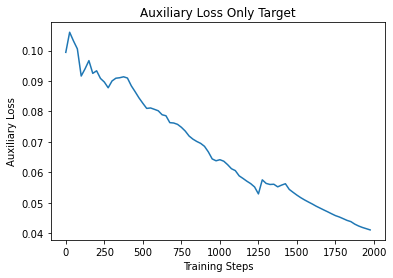

In [9]:
# plotting auxiliary loss
plt.figure()
plt.plot(train_steps, losses_aux)
plt.title('Auxiliary Loss Only Target')
plt.xlabel("Training Steps")
plt.ylabel("Auxiliary Loss")
plt.show()

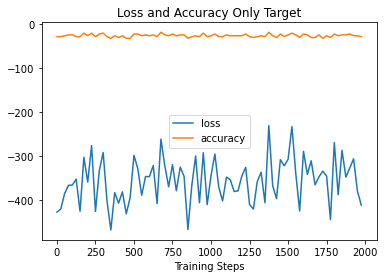

In [10]:
plt.figure()
plt.plot(train_steps, main_loss)
plt.plot(train_steps, accuracy)
plt.title('Loss and Accuracy Only Target')
plt.legend(('loss', 'accuracy'))
plt.xlabel("Training Steps")
plt.show()